# Chronos T5 


### Data For Chronos T5


In [1]:
import pandas as pd 
token = 'BTC-USD.csv'
data = pd.read_csv(token, parse_dates=['Date'], index_col=['Date'])
data.drop(['Adj Close', 'Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)


In [2]:
# Definir el número de días para el conjunto de prueba
prediction_length = 30

# Separar los datos
close_train = data['Close'][:-prediction_length]
close_test = data['Close'][-prediction_length:]
close_test


Date
2024-11-28     95652.468750
2024-11-29     97461.523438
2024-11-30     96449.054688
2024-12-01     97279.789062
2024-12-02     95865.304688
2024-12-03     96002.164062
2024-12-04     98768.531250
2024-12-05     96593.570312
2024-12-06     99920.710938
2024-12-07     99923.335938
2024-12-08    101236.015625
2024-12-09     97432.718750
2024-12-10     96675.429688
2024-12-11    101173.031250
2024-12-12    100043.000000
2024-12-13    101459.257812
2024-12-14    101372.968750
2024-12-15    104298.695312
2024-12-16    106029.718750
2024-12-17    106140.601562
2024-12-18    100041.539062
2024-12-19     97490.953125
2024-12-20     97755.929688
2024-12-21     97224.726562
2024-12-22     95104.937500
2024-12-23     94686.242188
2024-12-24     98676.093750
2024-12-25     99299.195312
2024-12-26     95795.515625
2024-12-27     93925.914062
Name: Close, dtype: float64

### Train Chronos T5 


In [4]:
import torch
from chronos import ChronosPipeline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
pipeline = ChronosPipeline.from_pretrained(
    'amazon/chronos-t5-small',
    device_map = device,
    torch_dtype = torch.float32
)

context = torch.tensor(close_train, dtype=torch.float32)


forecast = pipeline.predict(context, prediction_length, num_samples=100)

cuda


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

c:\Users\Ivo\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ivo\.cache\huggingface\hub\models--amazon--chronos-t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

C:\Users\Ivo\AppData\Local\Temp\ipykernel_2944\668353146.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context = torch.tensor(close_train, dtype=torch.float32)


In [5]:
import numpy as np
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
median

array([ 96776.875     ,  96776.875     ,  97538.8984375 ,  98300.921875  ,
        98110.40234375,  98681.90625   ,  98872.42578125,  99443.9296875 ,
        99062.9453125 , 100205.953125  ,  99634.4453125 ,  98872.42578125,
        99062.91796875, 100396.46875   , 100015.45703125, 100015.45703125,
       100015.45703125, 100586.984375  , 101539.5       , 100967.9765625 ,
       100967.9765625 , 101539.5       , 101729.9921875 , 102492.015625  ,
       101729.9921875 , 101729.9921875 , 101349.0078125 , 101539.5       ,
       101539.5       , 102111.03125   ])

### Graficas y Comparativa

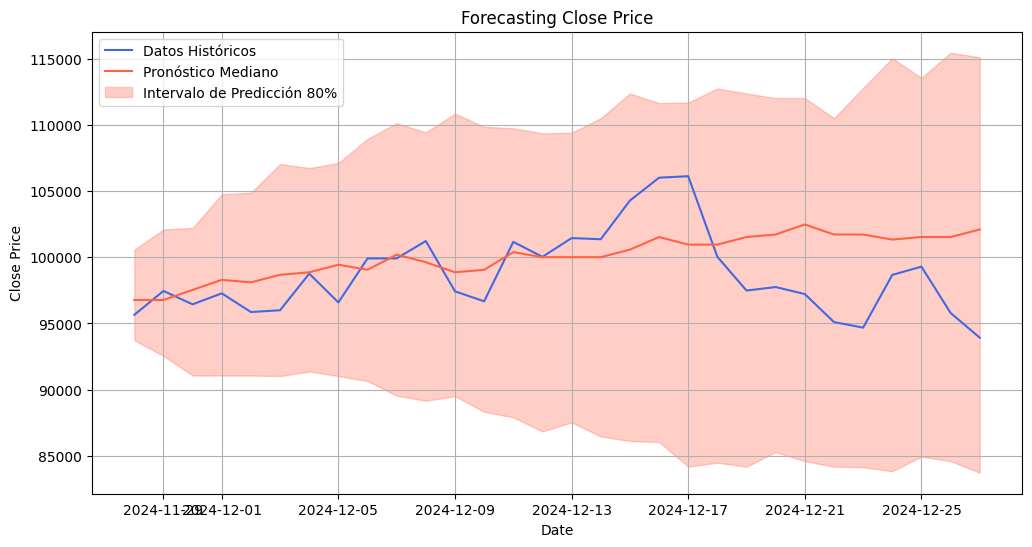

In [7]:
import matplotlib.pyplot as plt

# Graficar los datos históricos y el pronóstico junto con los datos de prueba
plt.figure(figsize=(12, 6))
plt.plot(close_test.index, close_test.values, label='Datos Históricos', color='royalblue')
plt.plot(close_test.index, median, label='Pronóstico Mediano', color='tomato')
plt.fill_between(close_test.index, low, high, color='tomato', alpha=0.3, label='Intervalo de Predicción 80%')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Forecasting Close Price')
plt.grid(True)
plt.show()


# Chronos-bolt-base

In [8]:
import torch
from chronos import BaseChronosPipeline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
pipeline = BaseChronosPipeline.from_pretrained(
    'amazon/chronos-bolt-base',
    device_map = device,
    torch_dtype = torch.float32
)

context = torch.tensor(close_train, dtype=torch.float32)


forecast = pipeline.predict(context, prediction_length)

cuda


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

c:\Users\Ivo\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ivo\.cache\huggingface\hub\models--amazon--chronos-bolt-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
import numpy as np
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
median

array([97381.9140625, 97356.0546875, 97096.75     , 97696.546875 ,
       98196.375    , 98357.265625 , 98311.109375 ])

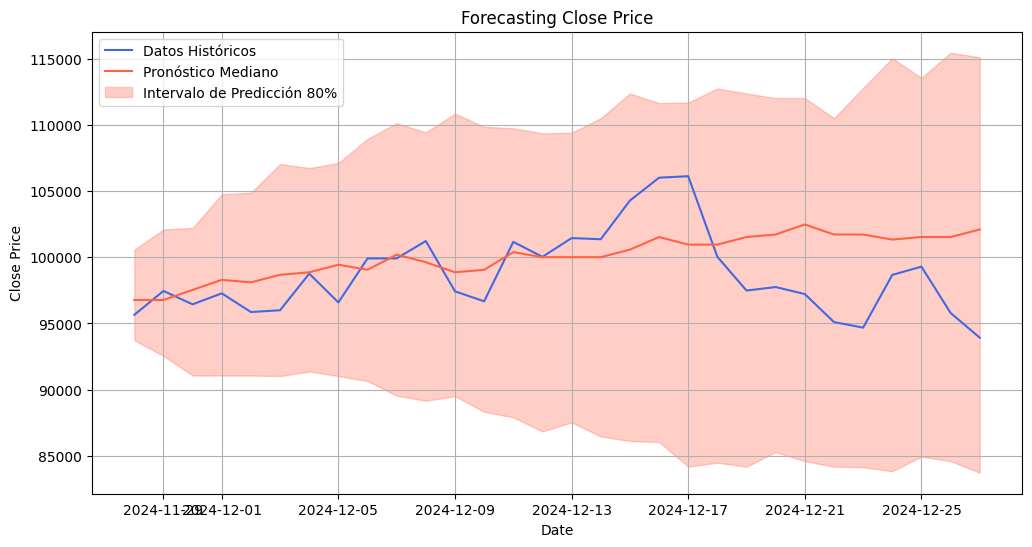

In [9]:
import matplotlib.pyplot as plt

# Graficar los datos históricos y el pronóstico junto con los datos de prueba
plt.figure(figsize=(12, 6))
plt.plot(close_test.index, close_test.values, label='Datos Históricos', color='royalblue')
plt.plot(close_test.index, median, label='Pronóstico Mediano', color='tomato')
plt.fill_between(close_test.index, low, high, color='tomato', alpha=0.3, label='Intervalo de Predicción 80%')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Forecasting Close Price')
plt.grid(True)
plt.show()